In [1]:
from lab4_proto import *

In [2]:
example = torch.load('lab4_example.pt')
example.keys()

dict_keys(['data', 'spectrograms', 'labels', 'input_lengths', 'label_lengths'])

In [3]:
def dataProcessing(data, transform):
    """
    process a batch of speech data
    arguments:
        data: list of tuples, representing one batch. Each tuple is of the form
            (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
        transform: audio transform to apply to the waveform
    returns:
        a tuple of (spectrograms, labels, input_lengths, label_lengths) 
        -   spectrograms - tensor of shape B x C x T x M 
            where B=batch_size, C=channel, T=time_frames, M=mel_band.
            spectrograms are padded the longest length in the batch.
        -   labels - tensor of shape B x L where L is label_length. 
            labels are padded to the longest length in the batch. 
        -   input_lengths - list of half spectrogram lengths before padding
        -   label_lengths - list of label lengths before padding
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    for i in range(len(data)):
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = data[i]
        # apply transform to waveform
        spectrogram = transform(waveform).squeeze(0).transpose(0, 1)
        # Shape of spectrogram is (time, n_mels)
        spectrograms.append(spectrogram)
        
        # convert utterance to list of integers
        label = strToInt(utterance)
        print(utterance)
        print(f"label: {label}")
        label = torch.tensor(label, dtype=torch.long)
        # append lengths
        input_lengths.append(spectrogram.shape[0] // 2)
        label_lengths.append(len(label))
        labels.append(label)


    max_input_length = max([s.shape[0] for s in spectrograms])
    max_label_length = max(label_lengths)
    for i in range(len(spectrograms)):
        if spectrograms[i].shape[0] < max_input_length:
            # pad spectrograms to max_input_length
            spectrograms[i] = torch.nn.functional.pad(
                spectrograms[i], (0, 0, 0, max_input_length - spectrograms[i].shape[0]), value=0)
        if len(labels[i]) < max_label_length:
            # pad labels to max_label_length
            labels[i] = torch.nn.functional.pad(
                labels[i], (0, max_label_length - len(labels[i])), value=0)
    
    # stack spectrograms and labels
    spectrograms = torch.stack(spectrograms, dim=0)
    spectrograms = spectrograms.unsqueeze(1).transpose(2, 3)
    labels = torch.stack(labels, dim=0)
    
    return spectrograms, labels, input_lengths, label_lengths

In [4]:
spectrograms, labels, input_lengths, label_lengths = dataProcessing(example["data"], train_audio_transform)

HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
label: [9, 6, 1, 9, 16, 17, 6, 5, 1, 21, 9, 6, 19, 6, 1, 24, 16, 22, 13, 5, 1, 3, 6, 1, 20, 21, 6, 24, 1, 7, 16, 19, 1, 5, 10, 15, 15, 6, 19, 1, 21, 22, 19, 15, 10, 17, 20, 1, 2, 15, 5, 1, 4, 2, 19, 19, 16, 21, 20, 1, 2, 15, 5, 1, 3, 19, 22, 10, 20, 6, 5, 1, 17, 16, 21, 2, 21, 16, 6, 20, 1, 2, 15, 5, 1, 7, 2, 21, 1, 14, 22, 21, 21, 16, 15, 1, 17, 10, 6, 4, 6, 20, 1, 21, 16, 1, 3, 6, 1, 13, 2, 5, 13, 6, 5, 1, 16, 22, 21, 1, 10, 15, 1, 21, 9, 10, 4, 12, 1, 17, 6, 17, 17, 6, 19, 6, 5, 1, 7, 13, 16, 22, 19, 1, 7, 2, 21, 21, 6, 15, 6, 5, 1, 20, 2, 22, 4, 6]
STUFF IT INTO YOU HIS BELLY COUNSELLED HIM
label: [20, 21, 22, 7, 7, 1, 10, 21, 1, 10, 15, 21, 16, 1, 26, 16, 22, 1, 9, 10, 20, 1, 3, 6, 13, 13, 26, 1, 4, 16, 22, 15, 20, 6, 13, 13, 6, 5, 1, 9, 10, 14]
AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID

In [5]:
spectrograms.shape, labels.shape, input_lengths, label_lengths

(torch.Size([5, 1, 80, 835]),
 torch.Size([5, 158]),
 [417, 131, 265, 107, 209],
 [158, 42, 104, 34, 59])

In [6]:
labels

tensor([[ 9,  6,  1,  9, 16, 17,  6,  5,  1, 21,  9,  6, 19,  6,  1, 24, 16, 22,
         13,  5,  1,  3,  6,  1, 20, 21,  6, 24,  1,  7, 16, 19,  1,  5, 10, 15,
         15,  6, 19,  1, 21, 22, 19, 15, 10, 17, 20,  1,  2, 15,  5,  1,  4,  2,
         19, 19, 16, 21, 20,  1,  2, 15,  5,  1,  3, 19, 22, 10, 20,  6,  5,  1,
         17, 16, 21,  2, 21, 16,  6, 20,  1,  2, 15,  5,  1,  7,  2, 21,  1, 14,
         22, 21, 21, 16, 15,  1, 17, 10,  6,  4,  6, 20,  1, 21, 16,  1,  3,  6,
          1, 13,  2,  5, 13,  6,  5,  1, 16, 22, 21,  1, 10, 15,  1, 21,  9, 10,
          4, 12,  1, 17,  6, 17, 17,  6, 19,  6,  5,  1,  7, 13, 16, 22, 19,  1,
          7,  2, 21, 21,  6, 15,  6,  5,  1, 20,  2, 22,  4,  6],
        [20, 21, 22,  7,  7,  1, 10, 21,  1, 10, 15, 21, 16,  1, 26, 16, 22,  1,
          9, 10, 20,  1,  3,  6, 13, 13, 26,  1,  4, 16, 22, 15, 20,  6, 13, 13,
          6,  5,  1,  9, 10, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0

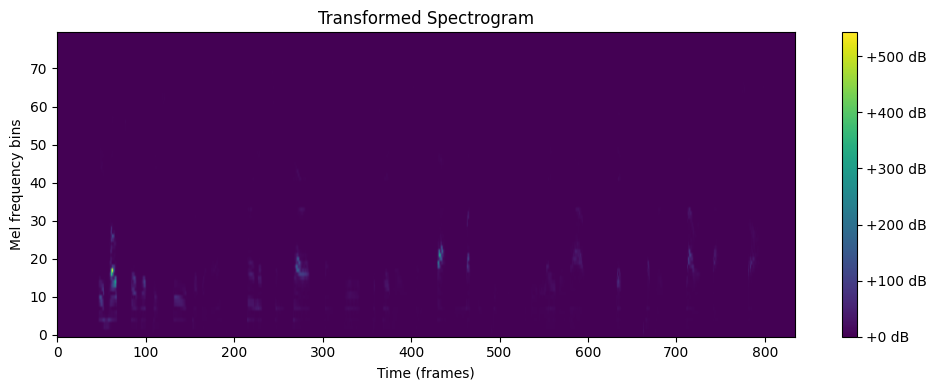

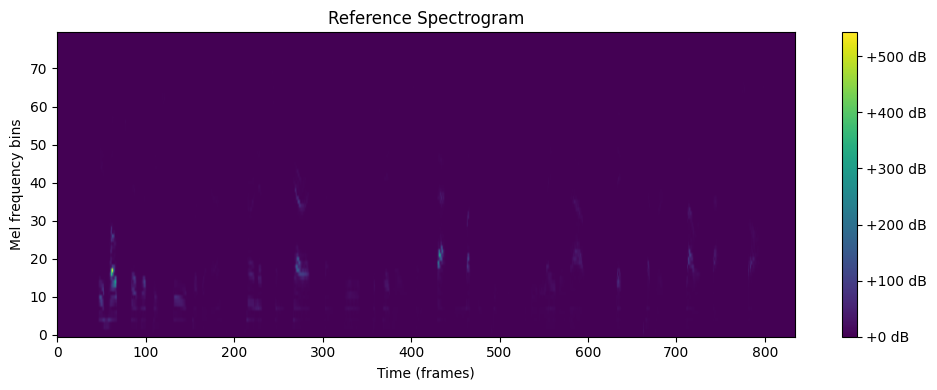

In [7]:
# Plot the spectrograms and the reference spectrograms (in example["spectrograms"])

import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram(spectrogram, title=None):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    if title:
        plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    plt.tight_layout()
    plt.show()
    
# Plot the first spectrogram
plot_spectrogram(spectrograms[0][0].numpy(), title="Transformed Spectrogram")
plot_spectrogram(example["spectrograms"][0][0].numpy(), title="Reference Spectrogram")